# Tema 4: Perceptronul multistrat - Pytorch


## Termen de predare: 12 ianuarie 2024, ora 23:00

## Descrierea temei
În cadrul acestei teme veți avea de implementat perceptronul multistrat în Pytorch. Veți lucra cu setul de date [FashionMnist](hhttps://www.kaggle.com/datasets/zalando-research/fashionmnist).

Puteți reutiliza și adapta cod din exemplul Pytorch pentru regresia logistică binară, din fișierul `Regresie logistică binomială` încărcat pe platformă în cadrul întâlnirii din 26 noiembrie. Modificările pe care trebuie să le aveți în vedere sunt:

1. În definirea lui Dataset nu se mai face filtrare după clasele pozitive si negative; se lasă toate datele (toate cele 10 clase)
1. În definirea clasei modelului, stratul self.fully_connected trebuie să fie cu numărul de ieșiri egal cu numărul de clase.
1. La predicție, pentru fiecare vector de intrare (imaginea reprezentată ca vector de 784 de valori) modelul produce un vector de 10 probabilități. Clasa se decide ca indicele pe care probabilitatea este maximă. Aceasta afectează implementarea funcției de testare
1. Funcția de eroare loss_fn este `torch.nn.CrossEntropyLoss`. Aceasta preia logiții produși de model.
1. Creați o matrice de confuzie pentru clase; puteți folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

 



In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.metrics import confusion_matrix

import seaborn as sns

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.1+cpu  Device: cpu


In [30]:
class FashionMNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        super(FashionMNISTDataset, self).__init__()
        self.path_csv = path_csv
        _csv_data = pd.read_csv(path_csv).values
        _x = _csv_data[:, 1:]
        _y = _csv_data[:, 0]
        
        self.x = _x
        self.y = _y
        
        self.x = torch.Tensor(self.x) / 255.0
        self.y = torch.Tensor(self.y).long()
        self.y = F.one_hot(self.y, num_classes=10).to(torch.float)
        
    def __len__(self) -> int:
        return self.x.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x[index, :], self.y[index]
    

In [31]:
fashion_mnist_train_ds = FashionMNISTDataset("./data/fashion-mnist_train.csv")
fashion_mnist_test_ds = FashionMNISTDataset("./data/fashion-mnist_test.csv")

In [32]:
fashion_mnist_train_dl = DataLoader(fashion_mnist_train_ds, batch_size=24, shuffle=True)
fashion_mnist_test_dl = DataLoader(fashion_mnist_test_ds, batch_size=24)

In [33]:
class MultiLayerPerceptronModel(nn.Module):
    def __init__(self, input_size = 784, hidden_size = 128, output_size = 10):
        super(MultiLayerPerceptronModel, self).__init__()
        self.fully_connected1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.fully_connected2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.fully_connected3 = nn.Linear(in_features=hidden_size, out_features=output_size)          
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.fully_connected1(x))
        x = self.relu(self.fully_connected2(x))
        x = self.fully_connected3(x)
        return F.softmax(x, dim=1)
        

In [34]:
model_mlp = MultiLayerPerceptronModel()
model_mlp

MultiLayerPerceptronModel(
  (fully_connected1): Linear(in_features=784, out_features=128, bias=True)
  (fully_connected2): Linear(in_features=128, out_features=128, bias=True)
  (fully_connected3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [35]:
def train_model(model = model_mlp, train_loader = fashion_mnist_train_dl, test_loader = fashion_mnist_test_dl):
    alpha = 0.05
    epochs = 50

    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(params=model.parameters(), lr=alpha)

    train_loss_values = []
    train_accuracies = []
    test_loss_values = []
    test_accuracies = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        total_items = 0
        train_correct = 0
        train_total = 0
        
        test_epoch_loss = 0
        test_total_items = 0
        test_correct = 0
        test_total = 0

        model.train()
        for (X_train, y_train) in train_loader:
            y_pred = model(X_train)
            
            loss = loss_fn(y_pred, y_train)
            epoch_loss += loss.item() * len(X_train)
            total_items += len(X_train)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_total += y_train.size(0)
            train_correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_train, axis=1)).sum().item()
        
        model.eval()

        with torch.inference_mode():
            for (X_test, y_test) in test_loader:
                test_pred = model(X_test)
                
                test_loss = loss_fn(test_pred, y_test)
                test_epoch_loss += test_loss.item() * len(X_test)
                test_total_items += len(X_test)
                
                test_total += y_test.size(0)
                test_correct += (torch.argmax(test_pred, axis=1) == torch.argmax(y_test, axis=1)).sum().item()
                
        epoch_loss /= total_items
        train_loss_values.append(epoch_loss)  
        
        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)

        test_epoch_loss /= test_total_items
        test_loss_values.append(test_epoch_loss)
                
        test_accuracy = test_correct / test_total
        test_accuracies.append(test_accuracy)       
        
        print(f"Epoch: {epoch + 1}/{epochs} | Training Loss: {epoch_loss:.8f} | Train accuracy: {train_accuracy * 100:.2f}% | Test Loss: {test_loss:.8f} | Test accuracy: {test_accuracy * 100:.2f}%")

    return np.array(train_loss_values), np.array(train_accuracies), np.array(test_loss_values), np.array(test_accuracies)


In [36]:
train_loss_values, train_accuracy_values, test_loss_values, test_accuracy_values = train_model(model=model_mlp, train_loader=fashion_mnist_train_dl, test_loader=fashion_mnist_test_dl)

Epoch: 1/50 | Training Loss: 1.91847299 | Train accuracy: 58.34% | Test Loss: 1.75890517 | Test accuracy: 76.75%
Epoch: 2/50 | Training Loss: 1.68827272 | Train accuracy: 78.17% | Test Loss: 1.71505928 | Test accuracy: 79.12%
Epoch: 3/50 | Training Loss: 1.66947443 | Train accuracy: 79.67% | Test Loss: 1.70737529 | Test accuracy: 80.28%
Epoch: 4/50 | Training Loss: 1.66071034 | Train accuracy: 80.36% | Test Loss: 1.70344377 | Test accuracy: 80.63%
Epoch: 5/50 | Training Loss: 1.65462285 | Train accuracy: 80.92% | Test Loss: 1.65883565 | Test accuracy: 80.71%
Epoch: 6/50 | Training Loss: 1.65123735 | Train accuracy: 81.23% | Test Loss: 1.70531356 | Test accuracy: 81.38%
Epoch: 7/50 | Training Loss: 1.64823081 | Train accuracy: 81.49% | Test Loss: 1.68867326 | Test accuracy: 80.70%
Epoch: 8/50 | Training Loss: 1.64614262 | Train accuracy: 81.65% | Test Loss: 1.69043565 | Test accuracy: 81.74%
Epoch: 9/50 | Training Loss: 1.64319324 | Train accuracy: 81.92% | Test Loss: 1.68497598 | Test 


## Suplimentar (și obligatoriu)
1. Pe un alt grafic să se prezinte: acuratețea pe setul de antrenare și pe setul de testare, la finalul fiecărei epoci (ambele scoruri pe acelasi grafic, cu legendă).
1. Să se calculeze și  să se afiseze matricea de confuzie (puteți folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).



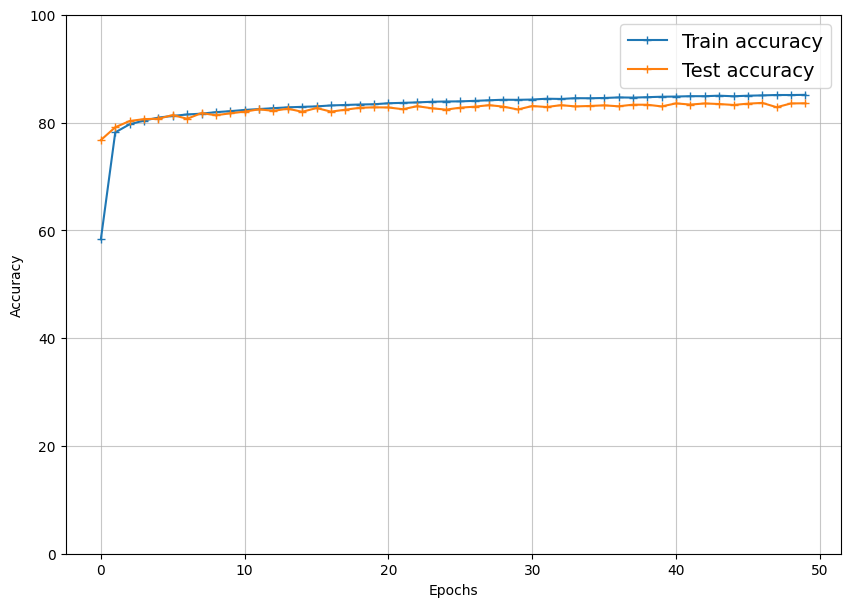

In [37]:
def plot_accuracies(train_acc = train_accuracy_values, test_acc = test_accuracy_values):
    plt.figure(figsize=(10,7))
    plt.plot(train_acc * 100, label='Train accuracy', marker='+', )
    plt.plot(test_acc * 100, label='Test accuracy', marker='+')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100)
    plt.legend(prop={"size" : 14})
    plt.grid(True, alpha=0.7)
    plt.show()

plot_accuracies()

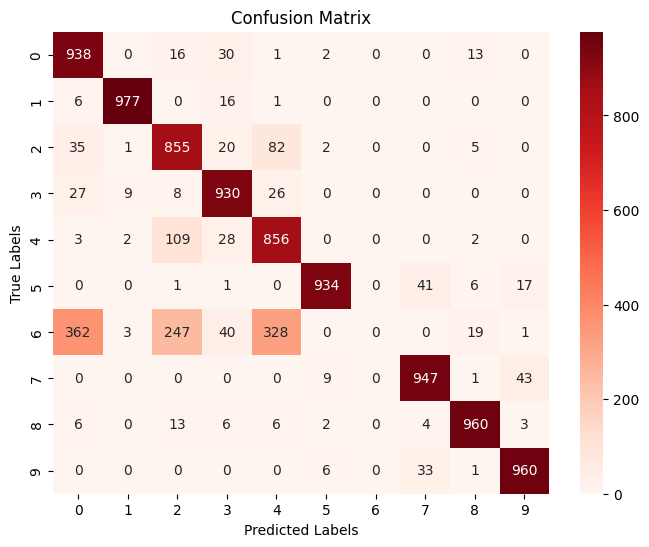

In [38]:
y_true_list = []
y_pred_list = []

model_mlp.eval()
with torch.inference_mode():
    for X_true, y_true in fashion_mnist_test_dl:
        y_pred = model_mlp(X_true)
        y_true_list.extend(torch.argmax(y_true, axis=1).numpy())
        y_pred_list.extend(torch.argmax(y_pred, axis=1).numpy())

conf_matrix = confusion_matrix(y_true_list, y_pred_list)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], yticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Suplimentar (opțional)

1. Pe un grafic să se prezinte loss-ul la finalul fiecărei epoci, pe setul de antrenare. Funcția de loss este aceeași ca în logistic regression, cazul multinomial
1. Implementați modificare de ponderi folosind metoda momentum.
1. Matricea de confuzie ca procent + colorare heatmap.

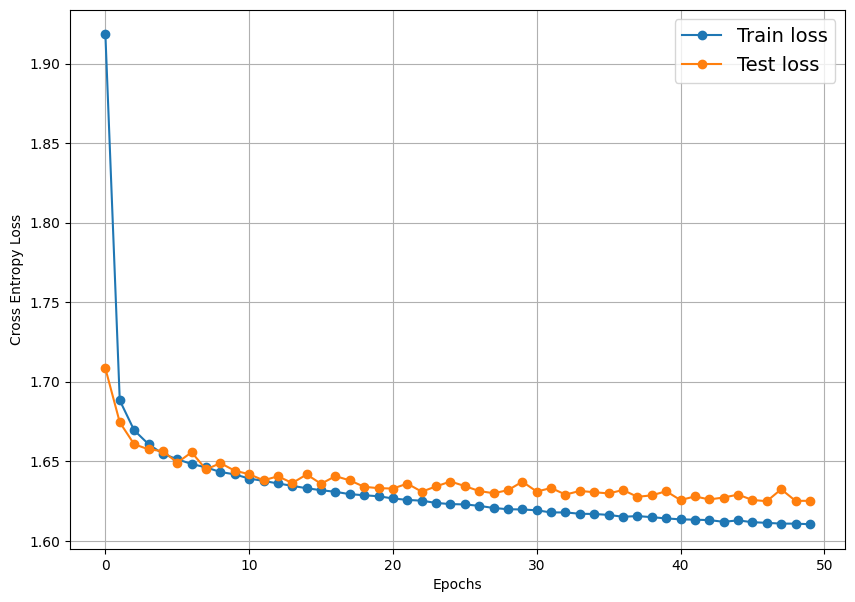

In [39]:
def plot_losses(train_loss = train_loss_values, test_loss = test_loss_values):
    plt.figure(figsize=(10,7))
    plt.plot(train_loss, label='Train loss', marker='o')
    plt.plot(test_loss, label='Test loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend(prop={"size" : 14})
    plt.grid()
    plt.show()

plot_losses()

In [40]:
class BinaryLogisticRegressionModel(nn.Module):
    def __init__(self, input_size=784, output_size = 10):
        super(BinaryLogisticRegressionModel, self).__init__()
        self.input_size = input_size
        self.fully_connected = nn.Linear(in_features=input_size, out_features=output_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fully_connected(x)
        x = torch.sigmoid(x)
        return x

In [41]:
model_blr = BinaryLogisticRegressionModel()
model_blr

BinaryLogisticRegressionModel(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

In [42]:
train_loss_values2, train_accuracy_values2, test_loss_values2, test_accuracy_values2 = train_model(model=model_blr, train_loader=fashion_mnist_train_dl, test_loader=fashion_mnist_test_dl)


Epoch: 1/50 | Training Loss: 1.76576923 | Train accuracy: 70.42% | Test Loss: 1.76106763 | Test accuracy: 73.52%
Epoch: 2/50 | Training Loss: 1.67999100 | Train accuracy: 74.28% | Test Loss: 1.72377086 | Test accuracy: 75.20%
Epoch: 3/50 | Training Loss: 1.65934147 | Train accuracy: 75.31% | Test Loss: 1.70232892 | Test accuracy: 75.77%
Epoch: 4/50 | Training Loss: 1.64735149 | Train accuracy: 76.29% | Test Loss: 1.68928182 | Test accuracy: 75.73%
Epoch: 5/50 | Training Loss: 1.63909855 | Train accuracy: 77.03% | Test Loss: 1.67678988 | Test accuracy: 76.90%
Epoch: 6/50 | Training Loss: 1.63296176 | Train accuracy: 77.57% | Test Loss: 1.67124200 | Test accuracy: 78.14%
Epoch: 7/50 | Training Loss: 1.62819520 | Train accuracy: 78.03% | Test Loss: 1.66270626 | Test accuracy: 78.21%
Epoch: 8/50 | Training Loss: 1.62437948 | Train accuracy: 78.60% | Test Loss: 1.65982270 | Test accuracy: 78.11%
Epoch: 9/50 | Training Loss: 1.62108742 | Train accuracy: 78.98% | Test Loss: 1.65516579 | Test 

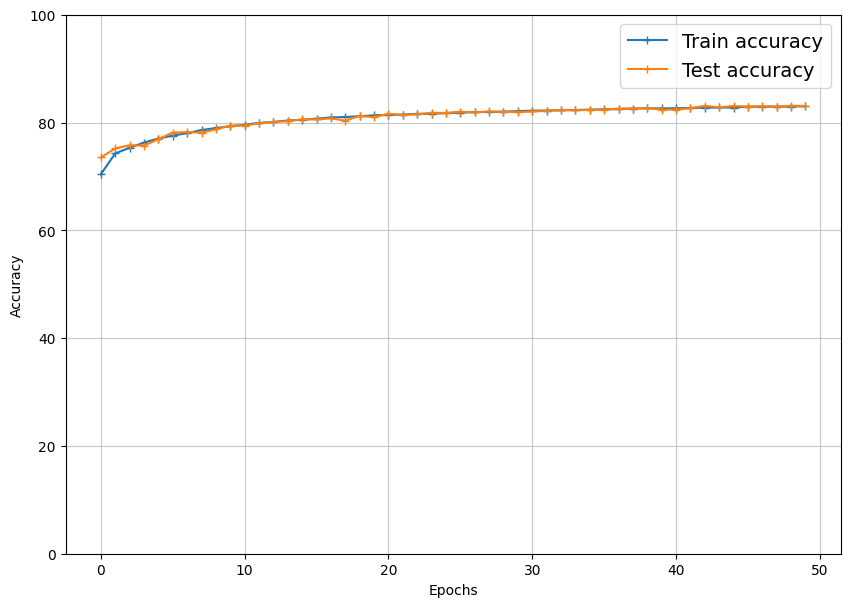

In [43]:
plot_accuracies(train_acc=train_accuracy_values2, test_acc=test_accuracy_values2)

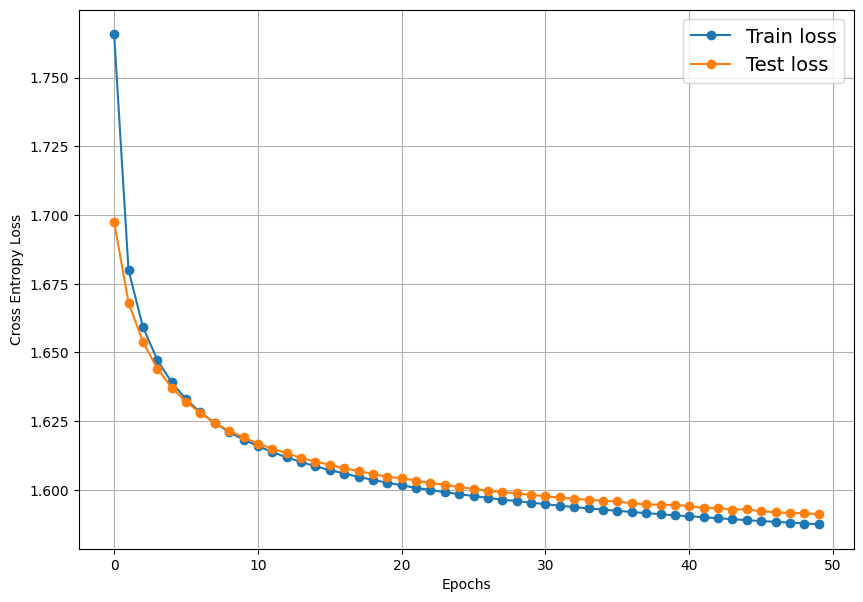

In [44]:
plot_losses(train_loss=train_loss_values2, test_loss=test_loss_values2)

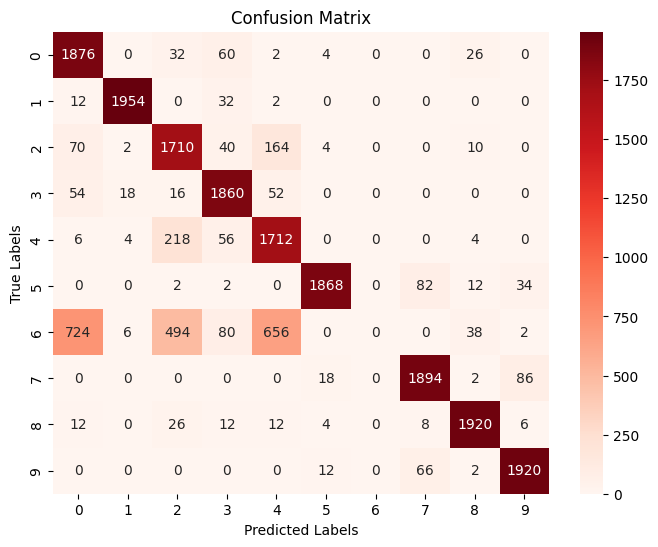

In [45]:
y_true_list2 = []
y_pred_list2 = []

model_blr.eval()
with torch.inference_mode():
    for X_true, y_true in fashion_mnist_test_dl:
        y_pred = model_mlp(X_true)
        y_true_list.extend(torch.argmax(y_true, axis=1).numpy())
        y_pred_list.extend(torch.argmax(y_pred, axis=1).numpy())

conf_matrix = confusion_matrix(y_true_list, y_pred_list)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], yticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()